In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

import os
import cv2

import numpy as np
from matplotlib import image as plt_image
import matplotlib.pyplot as plt
import argparse

from tensorflow.python.keras.models import model_from_json

# Preprocesado de datos

En primer lugar tenemos que obtener acceso a nuestro google drive


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Buscamos la url del datset dentro de nuestro drive y lo descomprimimos el dataset en la url indicadas

In [3]:
!unzip -u "/content/drive/MyDrive/Colab Notebooks/teller segmentacion/oxfordpets.zip" -d "/content/drive/MyDrive/Colab Notebooks/teller segmentacion/tmp"

Archive:  /content/drive/MyDrive/Colab Notebooks/teller segmentacion/oxfordpets.zip


In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/teller segmentacion/tmp/oxfordpets"


x = os.listdir(os.path.join(data_path, "images"))
y = os.listdir(os.path.join(data_path, "annotations/trimaps"))

x_aux = []
y_aux = []
for sample in x:
    if '.jpg' in sample:
        x_aux.append(sample)

for sample in y:
    if '.png' in sample:
        y_aux.append(sample)

x = x_aux
y = y_aux

# Ordenamos los nombres delos ficheros por sequencia
x.sort(key=lambda x: (x.split("_")[0], int(x.split(".")[0].split("_")[-1])))
y.sort(key=lambda x: (x.split("_")[0], int(x.split(".")[0].split("_")[-1])) )

print('Training size: ', len(x))
print(x[:5])
print(y[:5])

Training size:  7390
['Abyssinian_1.jpg', 'Abyssinian_2.jpg', 'Abyssinian_3.jpg', 'Abyssinian_4.jpg', 'Abyssinian_5.jpg']
['Abyssinian_1.png', 'Abyssinian_2.png', 'Abyssinian_3.png', 'Abyssinian_4.png', 'Abyssinian_5.png']


Cargamos los datos de entrenamiento en un numpy array.

En este ejemplo ce cargan solo las 100 primeras imágenes.

In [5]:
x_train = [plt_image.imread(os.path.join(data_path, "images", name)) for name in x[:1000]]
y_train = [plt_image.imread(os.path.join(data_path, "annotations/trimaps", name)) for name in y[:1000]]
print('Training size: ', len(x_train))

Training size:  1000


Para este caso de ejemplo vamos a ajustar el tamaño de los datos. Lo vamos a reducir desde su tamaño inicial (360, 640) a (128, 128) por tres motivos:


1.   Para ajustarlos al tamaño de entrada que nos interesa en la red neuronal
2.   Para que al realizar convoluciones con stride=2 no quede ninguna dimensión imapar. Si se diese ese caso luego tendríamos problemas para recuperar el tamaño original a la salida del autoencoder.
3.   Para simplificar y acelerar el procesamiento a efectos prácticos de este taller.




In [6]:
for i in range(len(x_train)):
    x_train[i] = cv2.resize(x_train[i], (128, 128))
    y_train[i] = cv2.resize(y_train[i], (128, 128))

In [7]:
# Se convierte x_train a un numpy array y eliminamos el canal alpha que aparece en algunas imágenes.
x_train = np.array([x[:, :, :3] for x in x_train])

Realizamos una visualización de los datos para ver que tras la transformación anterior siguen siendo correctos.

Input image shape:  (128, 128, 3)
Label image shape:  (128, 128)


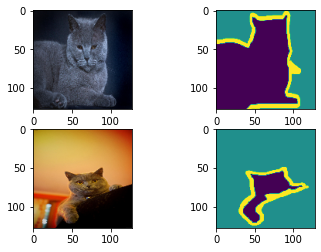

Train images range: : [ 0 ,  252 ]
Test images range: : [ 0.003921569 , 0.011764707 ]


In [8]:
n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

plt.subplot(2, 2, 1)
plt.imshow(img_in.astype(np.uint8))

plt.subplot(2, 2, 2)
plt.imshow(img_label)

n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

plt.subplot(2, 2, 3)
plt.imshow(img_in.astype(np.uint8))

plt.subplot(2, 2, 4)
plt.imshow(img_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Test images range: : [", np.amin(img_label), ",", np.amax(img_label), "]")

Como se puede observar en la celda anterior, los datos se encuentran en el rango de valores [0, 255]. Nos interesa normalizarlos al rango [0, 1] y convertirlos a tipo float32.

Posteriormente nos quedamos solo con uno de los tres canales de las imágenes segmentadas ya que se encuentran triplicados.

In [9]:
# Normalizamos los datos de entrada en rango [0, 1]
x_train = x_train / 255.
print(x_train.shape)

# transformamos los valores de y_train para que tengan información categórica en lugar de valores de intensidad (0.00392, 0.00784, 0.01176) -> (animal, fondo, borde)
y_train = np.array(y_train)
bins = np.array([0.0, 0.005, 0.01, 1.])
y_train = np.digitize(y_train, bins) - 1

# Expandimos las dimensiones de las eqtiquetas para que queden (w, h, 1)
y_train = np.expand_dims(y_train, axis=-1)

print(y_train.shape)


(1000, 128, 128, 3)
(1000, 128, 128, 1)


genes segmentadas a codificación one hot para que sean tratadas como etiquetas. De este modo la clase 0 se correspondera con el fondo de la imagen y la clase 1 con el primer plano.

In [10]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)  # one hot encoding

Revisamos la forma y los valores de los datos. Las etiquetas ahora tienen que tener forma (h, w, 2)

In [11]:
img_in = x_train[0]
img_label = y_train[0]
print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Test images range: : [", np.amin(img_label), ",", np.amax(img_label), "]")

Input image shape:  (128, 128, 3)
Label image shape:  (128, 128, 3)
Train images range: : [ 0.0 ,  0.9529411764705882 ]
Test images range: : [ 0.0 , 1.0 ]


Separamos un subconjunto de los datos para test.

In [12]:
# saparamos un subconjunto para test
test_split = 0.15
test_split = int(x_train.shape[0] * test_split)
test_idx = np.random.choice(x_train.shape[0], test_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in test_idx else True for i in
                       range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_test = x_train[test_idx]  # Seleccionamos datos de test
y_test = y_train[test_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Test samples: ', x_test.shape[0])

Train samples:  850
Test samples:  150


Separamos un subconjunto de los datos para hacer validación.

In [13]:
# saparamos un subconjunto de validación

val_split = 0.15
val_split = int(x_train.shape[0] * val_split)
val_idx = np.random.choice(x_train.shape[0], val_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in val_idx else True for i in range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_val = x_train[val_idx]  # Seleccionamos datos de validacón
y_val = y_train[val_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Train samples:  723
Validation samples:  127


# Autoencoder Variacional

Se puede dividir en dos componentes principales: el codificador y el decodificador.



1.   Codificador: Red neuronal que transforma la entrada y la comprime en un vector o huella latente de dimensiones reducidad.
2.   Decodificador: Red neuronal que transforma la huella latente en un vector de características de interes (reconstrucción/descompresión de datos, segmentación, imagen de profundidad)

En el autoencoder variacional la huella latente es una distribución normal multivariada. Esto se corresponde con la obtención de dos vectores, de los cuales uno guarda los valores de la media (μ) de cada distribución normal y el otro la varianza de cada uno (σ).



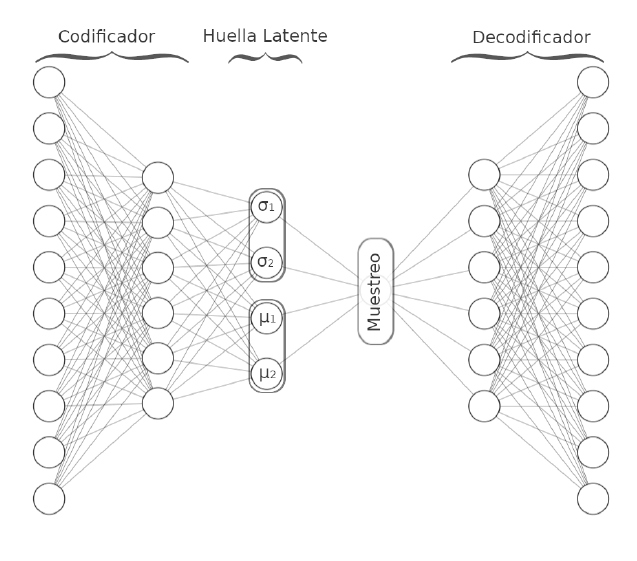

In [14]:
 def build_encoder(inputs, input_shape, kernel_size):
    # build encoder model
    x = inputs

    x = Conv2D(filters=64,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=64,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=128,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=256,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    # shape info needed to build decoder model
    last_conv_shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(last_conv_shape[1] * last_conv_shape[2] * last_conv_shape[3], activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    return encoder, z_mean, z_log_var, last_conv_shape

In [15]:
def build_decoder(latent_dim, shape): 
    # build decoder model
    latent_input = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)


    x = Conv2DTranspose(filters=256,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=128,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=64,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=64,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    output = Conv2DTranspose(filters=out_channels,
                          kernel_size=kernel_size,
                          activation='linear',
                          padding='same',
                          name='decoder_output')(x)  # Activación sigmoide para que las salidas estén en rango [0, 1]

    output = tf.keras.activations.softmax(output, axis=-1)
                
    # instantiate decoder model
    decoder = tf.keras.models.Model(latent_input, output, name='decoder')
    decoder.summary()
    
    return decoder

In [16]:
 def build_model(input_shape=(128, 128, 3), out_channels=1, latent_dim=128, kernel_size=3):
    # AE model = encoder + decoder
    inputs = Input(shape=input_shape, name='encoder_input')

    encoder, z_mean, z_log_var, last_conv_shape = build_encoder(inputs, input_shape, kernel_size)
    decoder = build_decoder(latent_dim, last_conv_shape) 
    
    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])  # Pasamos "z" (encoder(inputs)[2]) el decodificador

    labels = Input(shape=(*input_shape[:-1], out_channels), name='lables')

    vae =  tf.keras.models.Model([inputs, labels], outputs, name='vae')

    vae_loss = reconstruction_loss(labels, outputs, z_log_var, z_mean, input_shape)
    vae.add_loss(vae_loss)


    vae.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=tf.keras.metrics.CategoricalAccuracy())

    return encoder, decoder, vae


La pérdida en un VAE está compuesta por dos términos

1.   Pérdida de la reconstrucción: Esta mide cuanto se ajusta cada pixel de salida al valor de la etiqueta correspondiente.
2.   Término de regulación KL (Kullback–Leibler): Controla que el espacio latente esté formado un distribución normal multivariada centrada en cero.



In [17]:
def reconstruction_loss(y_true, y_pred, z_log_var, z_mean, input_shape):

    # reconstruction_loss =  tf.keras.losses.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss = tf.keras.losses.categorical_crossentropy(K.flatten(y_true), K.flatten(y_pred))

    reconstruction_loss /= input_shape[0] * input_shape[1]

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = - K.mean(kl_loss, axis=-1)
    beta = 0.5
    vae_loss = K.mean(reconstruction_loss + beta * kl_loss)

    return vae_loss

A la hora de muestrear de las distribuciones normales que forman la huella latente es necesario utilizar un truco para que sea posible retropropagar el gradiente. Esto se debe a que muestrear de una distribución normal no es una operación derivable.

Con este fin, se introduce la variable "epsilon" que es un vector de valores que se oftienen muestreando de una distribución normal N(0, 1). El valor de epsilon se utiliza para hacer la selección de z mediante la ecuación: 

z = z_mean + sigma * epsilon 

donde  sigma = e^(z_var/2)

In [18]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Construimos el modelo de VAE.
Seleccionamos el número de canales en función del número de etiquetas.

In [19]:
input_shape=(128, 128, 3)
out_channels=3
latent_dim=256
kernel_size=3

encoder, decoder, vae = build_model(input_shape, out_channels, latent_dim, kernel_size)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 128)  73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Entrenamos el VAE.

En keras normalmente tendríamos que los datos de entrada son x_train y y_train se introducen como etiquetas tal que:

```
vae.fit(x_train, y_train, epochs...)
```

En este caso hemos definido una función de pérdida especial y se la hemos asignado al modelo de una forma "no estandar". Por esto, hemos creado los dos tensores de entrada "input" para x_train y "labels" para y_train. En esta situación tenemos que introducir los datos de la siguiente forma:

```
vae.fit([x_train, y_train], None, epochs...)
```

Donde `[x_train, y_train]` son las dos entradas a nuestro modelo de Keras y dado que nuestra función de pérdidas no utiliza la variable de entrada por defecto para las etiquetas de la función, en esta se introduce un "None".

Por último, hemos añadido una metrica de la forma convencional. Para que esta métrica funcione debemos introducir las etiquetas de forma convencional. Por lo tanto, introduciremos las etiquetas tanto en el tensor de entrada que hemos preparado para ello como en su variable dedicada de la función fit, es decir:

```
vae.fit([x_train, y_train], y_train, epochs...)
```

En el caso de los datos de validación hay que introducirlos siguiendo las mismas reglas:

```
validation_data=([x_val, y_val], y_val)
```


In [ ]:
batch_size = 64
epochs = 30

vae.fit([x_train, y_train], y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=([x_val, y_val], y_val))

Epoch 1/30
12/12 [==============================] - 125s 10s/step - loss: 899.4292 - categorical_accuracy: 0.4735 - val_loss: 949.2552 - val_categorical_accuracy: 0.5885
Epoch 2/30
12/12 [==============================] - 125s 10s/step - loss: 898.9358 - categorical_accuracy: 0.5618 - val_loss: 947.8875 - val_categorical_accuracy: 0.5886
Epoch 3/30
12/12 [==============================] - 128s 11s/step - loss: 894.4111 - categorical_accuracy: 0.5618 - val_loss: 934.2241 - val_categorical_accuracy: 0.5886
Epoch 4/30
12/12 [==============================] - 127s 11s/step - loss: 884.4360 - categorical_accuracy: 0.5618 - val_loss: 928.0048 - val_categorical_accuracy: 0.5886
Epoch 5/30
12/12 [==============================] - 128s 11s/step - loss: 881.5377 - categorical_accuracy: 0.5618 - val_loss: 927.0515 - val_categorical_accuracy: 0.5886
Epoch 6/30
12/12 [==============================] - 127s 11s/step - loss: 880.7781 - categorical_accuracy: 0.5618 - val_loss: 926.6207 - val_categoric

Salvamos el modelo. En este caso guardamos el Codificador y DEcodificador por separado por dos motivos:


1.   Nos puede interesar utilizar en el futuro una de las dos partes independientemente
2.   La unión entre los dos es un poco especial ya que pasan tres tensores de uno a otro y hemos tenido que hacerlo de forma no "estandar". En este caso Keras da problemas al guardarlo como un solo problema.

Solo guardamos los pesos debido a que ya tenemos el modelo completo en el notebook.



In [ ]:
encoder_path = '/content/drive/MyDrive/Colab Notebooks/teller segmentacion/Modelos_salvados/oxfordpets_encoder_128_128_128_256'
decoder_path = '/content/drive/MyDrive/Colab Notebooks/teller segmentacion/Modelos_salvados/oxfordpets_decoder_128_128_128_256'

save_name = encoder_path
encoder.save_weights(save_name + ".h5")
print("Encoder saved  to disk")

save_name = decoder_path
decoder.save_weights(save_name + ".h5")
print("Decoder saved  to disk")

Hemos preentrenado un modelo para que podais testear los resultados. Procedemos a cargarlo.

In [ ]:
# Si no se hubiese creado el modelo todavía habria que crear uno nuevo con la siguiente linea
# encoder, decoder, vae = build_model(input_shape)

# load weights into new model
encoder.load_weights(encoder_path + ".h5")

# load weights into new model
decoder.load_weights(decoder_path + ".h5")

# Si fuesemos a reentrenar necesitariamos compilamos el modelo de nuevo
# vae.compile(optimizer='adam')

# Testing
En este caso ya hemos tratado el conjunto de test anteriormente por lo que vamos a evaluarlo directamente.

la función evaluate realiza un predict sobre cada entrada del conjunto de test y extrae las métricas que hayamos indicado al compilar el modelo.

In [ ]:
vae.evaluate([x_test, y_test], y_test, batch_size=batch_size)

Por último, vamos a visualizar algunos de los resultados. 

La siguiente celda selecciona varias imágenes aleatorias y muestra su salida.

In [ ]:
figsize = 5
num_examples_to_generate = figsize*figsize
fig = plt.figure()
fig.suptitle('Resultados segmentación')
examples_index = np.random.choice(x_test.shape[0], figsize*2)
examples = x_test[examples_index]
z_mean, z_log_var, z = encoder.predict(examples)
predictions = decoder.predict(z_mean)


predictions = np.argmax(predictions, axis=-1)

for i in range(figsize*2):

    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(predictions[i])

plt.axis('off')
plt.show()

Una característica interesande de los VAE es que su decodificador es un modelo generador. Podemos crear una huella latente y ajustar sus parámetros para obtener imágenes nuevas.

Por ejemplo con una red que segmente el tráfico, podríamos crear imagenes de segmentación de nuevas situaciones y a su vez utilizarlas para entrenar otro algoritmo en el manejo de un vehículo autónomo.

En la celda siguiente se muestrean varias huellas latented sobre una distribución normal para ver nuevos ejemplos.



In [ ]:


random_vector_for_generation = np.random.normal(size=(num_examples_to_generate, latent_dim))

predictions = decoder.predict(random_vector_for_generation)

predictions = np.argmax(predictions, axis=-1)
fig = plt.figure(figsize=(figsize, figsize))
fig.suptitle('Nuevos ejemplos generados')
for i in range(num_examples_to_generate):
    plt.subplot(figsize, figsize, i+1)
    plt.imshow(predictions[i])
plt.axis('off')